In [18]:
%matplotlib inline
import sys
from collections import namedtuple
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from uncertainty import compute_variation_ratio
from uncertainty import compute_predictive_entropy
from uncertainty import compute_mutual_information

In [2]:
print(sys.version)
print(tf.version.VERSION)
print(tfp.__version__)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
1.14.0
0.7.0


In [3]:
seed = 0
random_state = 0
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

# Toy data generation
*  [sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [4]:
n_samples = int(1e4)

n_features = 20
n_classes = 2

n_informative = 5
n_redundant = 2

x, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_classes=n_classes,
    random_state=random_state)

y = tfk.utils.to_categorical(y).astype(np.int64)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2 / 0.8)

In [19]:
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_valid = minmax.transform(x_valid)
x_test = minmax.transform(x_test)

Datasets = namedtuple('Datasets', ['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test'])
datasets = Datasets(x_train, y_train, x_valid, y_valid, x_test, y_test)

# Data Visualization

In [6]:
num_vis = min(len(x_test), 500)
vis_indices = np.random.choice(np.arange(len(x_test)), num_vis)
x_vis = x_test[vis_indices]
y_vis = y_test[vis_indices]

In [7]:
# df = {'x{}'.format(i): x_vis[:, i] for i in [1, 3, 5, 7, 9]}
df = {'x{}'.format(i): x_vis[:, i] for i in range(0, n_features, 4)}
variables = list(df.keys())
print(variables)
df['y'] = y_vis[:, 1]
df = pd.DataFrame(df)

['x0', 'x4', 'x8', 'x12', 'x16']


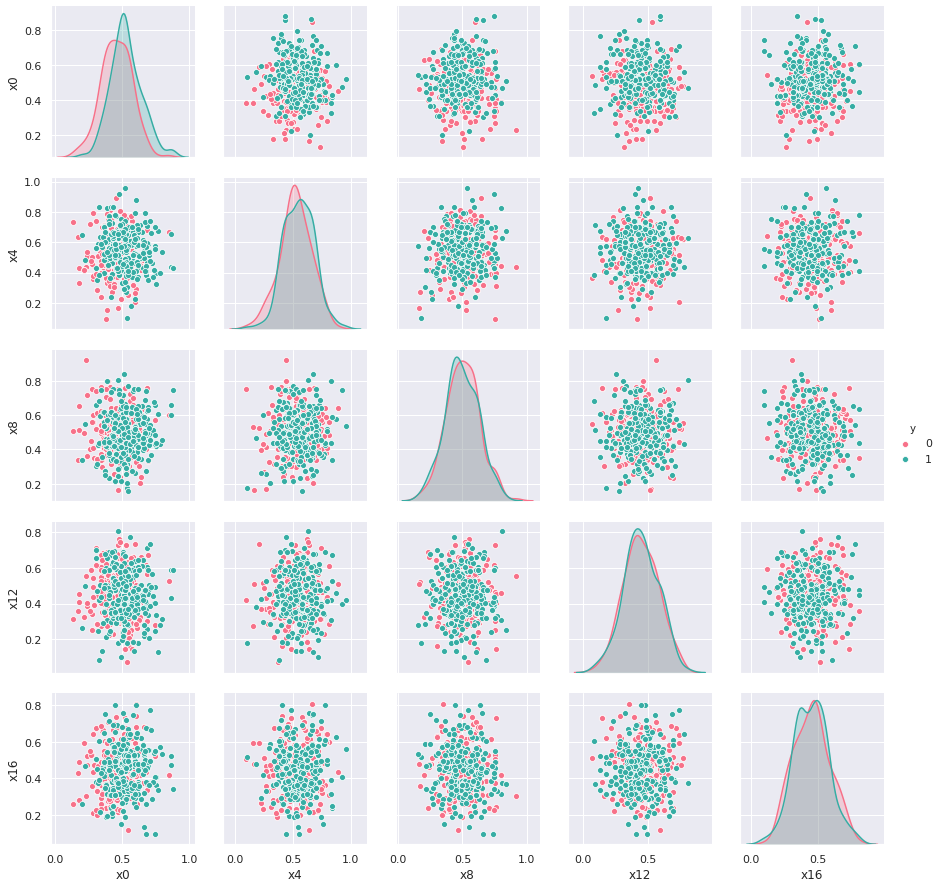

In [8]:
sns.pairplot(df, hue='y', vars=variables, palette="husl")

Text(0.5, 1.0, 't-SNE')

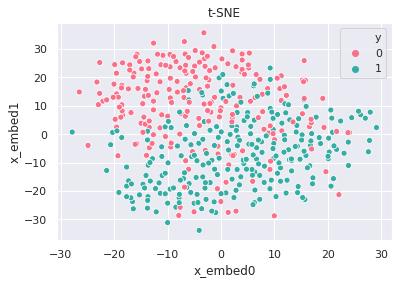

In [9]:
tsne = TSNE(random_state=random_state)
x_embed = tsne.fit_transform(x_vis)
df['x_embed0'] = x_embed[:, 0]
df['x_embed1'] = x_embed[:, 1]
ax = sns.scatterplot(data=df, x='x_embed0', y='x_embed1', hue='y', palette="husl")
ax.set_title("t-SNE")

# Create deterministic model

In [10]:
def plot_learning_curve(history, title=None):
    kwargs = {'ls': '--', 'marker': 'o'}

    fig, axarr = plt.subplots(ncols=2, figsize=(16, 6))
    axarr[0].plot(history.history['loss'], label='Training', **kwargs)
    axarr[0].plot(history.history['val_loss'], label="Validation", **kwargs)
    axarr[0].set_title("Loss")
    axarr[0].set_xlabel('Epoch')
    axarr[0].legend()

    axarr[1].plot(history.history['acc'], label='Training', **kwargs)
    axarr[1].plot(history.history['val_acc'], label="Validation", **kwargs)
    axarr[1].set_title("Accuracy")
    axarr[1].set_xlabel('Epoch')
    axarr[1].legend()
    
    if title is not None:
        fig.suptitle(title)

In [20]:
def run_experiment(model,
                   loss,
                   datasets,
                   title=None,
                   learning_rate=0.01,
                   epochs=100,
                   batch_size=256):
    
    model.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=loss,
        metrics=['accuracy'])

    history = model.fit(
        datasets.x_train,
        datasets.y_train,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        validation_data=(datasets.x_valid, datasets.y_valid),
        verbose=False)


    loss, acc = model.evaluate(datasets.x_test, datasets.y_test, verbose=False)
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    
    
    # plotting
    plot_learning_curve(history, title)
    
    return acc

In [12]:
kl_weight = 1 / len(x_train)
print(kl_weight)

0.00016666666666666666


In [13]:
def negative_log_likelihood(y_true, y_pred_rv):
    return -y_pred_rv.log_prob(y_true)

In [14]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    # NOTE When c = np.log(np.expm1(1.)), training is very unstable
    # c = np.log(np.expm1(1.))
    c = 0
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(
                    loc=t[..., :n],
                    scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
  ])

In [15]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1),
                reinterpreted_batch_ndims=1)),
    ])

In [16]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfpl.DenseVariational(
        units=128,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfkl.ReLU(),
    tfpl.DenseVariational(
        units=tfpl.OneHotCategorical.params_size(n_classes) - 1,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfk.layers.Lambda(lambda x: tf.pad(x, paddings=[[0, 0], [1, 0]])),
    tfpl.OneHotCategorical(n_classes),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 128)               8064      
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dense_variational_1 (DenseVa (None, 1)                 387       
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0         
_________________________________________________________________
one_hot_categorical (OneHotC ((None, 2), (None, 2))    0         
Total params: 8,451
Trainable params: 8,451
Non-trainable params: 0
_________________________________________________________________


Loss: 0.4078
Accuracy: 0.7610


0.761

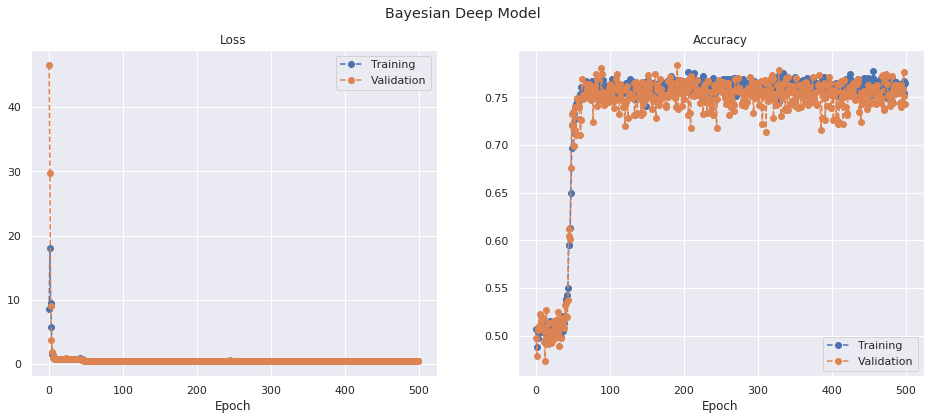

In [22]:
model.set_weights(initial_weights)

run_experiment(model,
               negative_log_likelihood,
               datasets,
               'Bayesian Deep Model',
               learning_rate=0.1,
               epochs=500)

In [25]:
prediction_samples = tf.stack([model(x_test).probs for _ in range(100)]).numpy()

In [26]:
mu = prediction_samples[:, :, 1].mean(axis=0)
sigma = prediction_samples[:, :, 1].std(axis=0)
variation_ratio = compute_variation_ratio(prediction_samples)
predictive_entropy = compute_predictive_entropy(prediction_samples)
mutual_information = compute_mutual_information(prediction_samples)

In [27]:
def plot_uncertainty(mu, uncertainty, title=None):
    is_zero = y_test[:, 1] == 0
    is_one = y_test[:, 1] == 1
    
    fig, axarr = plt.subplots(ncols=2, figsize=(12, 6))
    axarr[0].scatter(mu[is_zero], uncertainty[is_zero], s=5, alpha=0.1)
    axarr[0].set_xlim(0, 1)
    axarr[1].scatter(mu[is_one], uncertainty[is_one], s=5, alpha=0.1)
    axarr[1].set_xlim(0, 1)
    
    if title is not None:
        fig.suptitle(title)

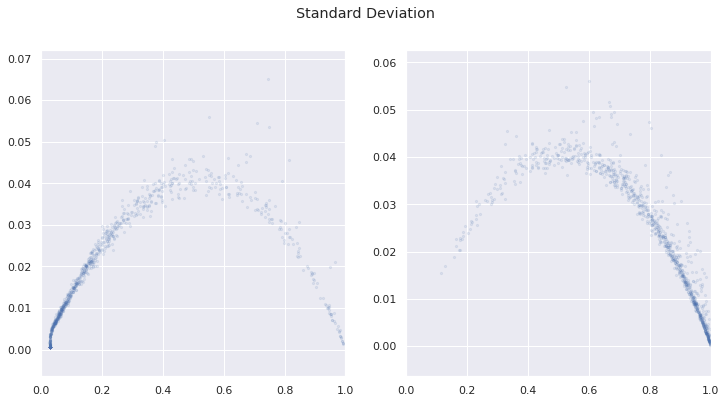

In [28]:
plot_uncertainty(mu, sigma, title='Standard Deviation')

In [ ]:
plot_uncertainty(mu, variation_ratio, title='Variation Ratio')

In [ ]:
plot_uncertainty(mu, predictive_entropy, title="Predictive Entropy")

In [ ]:
plot_uncertainty(mu, mutual_information, title="Mutual Information")

In [ ]:
mu = prediction_samples[:, :, 1].mean(0)
roc_auc =  metrics.roc_auc_score(y_true=y_test[:, 1], y_score=mu)
accuracy = metrics.accuracy_score(y_true=y_test[:, 1], y_pred=mu > 0.5)

print(f'ROC AUC: {roc_auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')

In [66]:
result = [(mu, metrics.roc_auc_score(y_test[:, 1][sigma < cut], mu[sigma < cut])) for cut in np.linspace(sigma.min(), sigma.max())]
a, b = zip(*result)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
uncertainty_data = []
auc_data = []
acc_data = []
for cut in np.linspace(sigma.min(), sigma.max()):
    y_true = y_test[:, 1][sigma < cut]
    y_score = mu[sigma < cut]
    
    if len(y_true) == 0 or len(y_score) == 0:
        continue
        
    roc_auc = metrics.roc_auc_score(y_true, y_score)
    acc = metrics.accuracy_score(y_true, y_score > 0.5)
    
    uncertainty_data.append(cut)
    auc_data.append(roc_auc)
    acc_data.append(acc)

In [ ]:
plt.plot(uncertainty_data, auc_data)

In [ ]:
plt.plot(uncertainty_data, acc_data)